<a href="https://colab.research.google.com/github/seymadogru/BasicDataTypes/blob/master/Warehouse_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import gym
from gym import spaces
import numpy as np
import time
from IPython.display import clear_output

class StrictCombinedEnv(gym.Env):
    def __init__(self):
        super(StrictCombinedEnv, self).__init__()

        self.grid_size = 12
        self.map = np.zeros((self.grid_size, self.grid_size), dtype=int)

        self._generate_map()

        self.action_space = spaces.Discrete(5) # 0-3: Hareket, 4: İşlem

        # Gözlem: [X, Y, Slot1, Slot2, Batarya]
        low = np.array([0, 0, 0, 0, 0])
        high = np.array([self.grid_size, self.grid_size, 6, 6, 11])
        self.observation_space = spaces.Box(low, high, dtype=np.int32)

        self.agent_pos = [0, 0]
        self.slots = [0, 0]
        self.battery = 100.0
        self.order_list = []
        self.max_steps = 800 # Süreyi biraz daha uzattık
        self.current_step = 0

    def _generate_map(self):
        self.map.fill(0)
        self.map[0, 0] = 2 # DOCK + ŞARJ

        # Labirent
        for _ in range(25):
            x, y = np.random.randint(1, 11, 2)
            if (x,y) != (0,0): self.map[x, y] = 1

        self.shelves = {
            1: [11, 11], 2: [0, 11], 3: [11, 5], 4: [5, 5], 5: [5, 0]
        }
        for k, pos in self.shelves.items():
            self.map[pos[0], pos[1]] = 10 + (k-1)

    def reset(self):
        self.agent_pos = [0, 0]
        self.slots = [0, 0]
        self.battery = 100.0
        self.current_step = 0
        self.order_list = list(np.random.choice([1, 2, 3, 4, 5], 8)) # 8 Ürünlük İş
        return self._get_obs()

    def _get_obs(self):
        return np.array([self.agent_pos[0], self.agent_pos[1], self.slots[0], self.slots[1], int(self.battery/10)])

    def _dist(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def step(self, action):
        self.current_step += 1
        reward = -0.1 # Zaman cezası (Hızlanmaya teşvik)
        done = False

        # Enerji
        carried_count = (1 if self.slots[0] > 0 else 0) + (1 if self.slots[1] > 0 else 0)
        self.battery -= (0.2 + carried_count * 0.1)

        if self.battery <= 0:
            return self._get_obs(), -100, True, {} # Pil Bitti = OYUN BİTTİ

        # Hareket
        prev_pos = self.agent_pos.copy()
        if action == 0: self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1: self.agent_pos[0] = min(self.grid_size - 1, self.agent_pos[0] + 1)
        elif action == 2: self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3: self.agent_pos[1] = min(self.grid_size - 1, self.agent_pos[1] + 1)

        if self.map[self.agent_pos[0], self.agent_pos[1]] == 1:
            reward -= 2
            self.agent_pos = prev_pos

        # --- HEURISTIC (Yönlendirme) ---
        target_pos = None

        # 1. ACİL DURUM: Pil azsa DÖN
        if self.battery < 30:
            target_pos = [0, 0]

        # 2. İŞ ALMA: Çanta boşsa veya yer varsa VE iş varsa DÖN
        elif (0 in self.slots) and (len(self.order_list) > 0):
             # Eğer çanta tamamen boşsa kesin dön
             if sum(self.slots) == 0: target_pos = [0, 0]
             # Eğer yarı doluysa ve yakındaysan dön (Basitleştirme: her türlü dön)
             else: target_pos = [0, 0]

        # 3. DAĞITIM: Çanta doluysa RAFA GİT
        elif sum(self.slots) > 0:
            targets = []
            if self.slots[0] > 0: targets.append(self.shelves[self.slots[0]])
            if self.slots[1] > 0: targets.append(self.shelves[self.slots[1]])

            if len(targets) > 0:
                dists = [self._dist(self.agent_pos, t) for t in targets]
                target_pos = targets[np.argmin(dists)]

        if target_pos:
            d_old = self._dist(prev_pos, target_pos)
            d_new = self._dist(self.agent_pos, target_pos)
            if d_new < d_old: reward += 0.25 # Yaklaşma ödülünü artırdık
            elif d_new > d_old: reward -= 0.15

        # --- ETKİLEŞİM ---
        curr_cell = self.map[self.agent_pos[0], self.agent_pos[1]]

        if action == 4:
            # DOCK + ŞARJ (Cell 2)
            if curr_cell == 2:
                action_performed = False

                # A) Şarj İhtiyacı Var mı?
                if self.battery < 60: # %60 altındaysa şarj et
                    self.battery = 100.0
                    reward += 10 # Şarj ödülü
                    action_performed = True

                # B) Yük Alınacak mı?
                # Pil durumu iyiyse (%40 üstü) VE yer varsa VE iş varsa
                elif self.battery >= 40 and (0 in self.slots) and (len(self.order_list) > 0):
                    loaded = 0
                    while 0 in self.slots and len(self.order_list) > 0:
                        empty_idx = self.slots.index(0)
                        self.slots[empty_idx] = self.order_list.pop(0)
                        loaded += 1

                    if loaded > 0:
                        reward += 30 # Yükleme ödülü
                        action_performed = True
                        # Fırsat Şarjı: Yüklerken %100 yap
                        self.battery = 100.0

                # C) HİÇBİR ŞEY YAPMADI MI? (TEMBELLİK CEZASI)
                # Pili dolu, çantası dolu veya iş yok ama hala istasyonda bekliyor.
                if not action_performed:
                    reward -= 10 # BÜYÜK CEZA! "Burada boş durma git!"

            # RAF (Bırakma)
            elif curr_cell >= 10:
                shelf_type = curr_cell - 10 + 1
                delivered = False
                for i in range(2):
                    if self.slots[i] == shelf_type:
                        self.slots[i] = 0
                        reward += 80 # Teslimat ödülü yüksek
                        delivered = True
                        break
                if not delivered: reward -= 5 # Yanlış yere bırakma cezası
            else:
                reward -= 2 # Boş yolda işlem yapma cezası

        if len(self.order_list) == 0 and sum(self.slots) == 0:
            reward += 200 # Görev bitiş bonusu
            done = True

        if self.current_step >= self.max_steps:
            done = True

        return self._get_obs(), reward, done, {}

    def render(self):
        print(f"\n--- DİSİPLİNLİ AGENT SİSTEMİ ---")
        d_bat = int(self.battery)
        col = "🟢" if d_bat > 40 else "🔴"
        print(f"BATARYA: {col} [{'▮'*int(d_bat/5)}{' '*(20-int(d_bat/5))}] %{d_bat}")
        s1 = chr(64+self.slots[0]) if self.slots[0]>0 else "-"
        s2 = chr(64+self.slots[1]) if self.slots[1]>0 else "-"
        print(f"YÜK    : [📦 {s1}] [📦 {s2}]")
        print(f"KALAN  : {len(self.order_list)} paket.")
        if len(self.order_list) > 0:
            print(f"SIRADA : {' -> '.join([chr(64+x) for x in self.order_list[:4]])} ...")

        for x in range(self.grid_size):
            row = ""
            for y in range(self.grid_size):
                cell = self.map[x, y]
                if x==self.agent_pos[0] and y==self.agent_pos[1]:
                    if sum(self.slots) == 2: row+="🚛"
                    elif sum(self.slots) == 1: row+="🚚"
                    else: row+="🤖"
                elif cell==1: row+="🧱"
                elif cell==2: row+="⛽"
                elif cell>=10: row+=chr(55+cell)+" "
                else: row+=". "
            print(row)

In [6]:
import matplotlib.pyplot as plt

env = StrictCombinedEnv()
q_table = {}

alpha = 0.2
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.9997
min_epsilon = 0.05

def get_state_key(obs):
    return tuple(obs)

history_rewards = []
print("Disiplinli Eğitim Başlıyor (Tembellik Yasak)...")

episodes = 40000 # İyice öğrensin
for episode in range(episodes):
    obs = env.reset()
    state = get_state_key(obs)
    done = False
    total_reward = 0

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
            action = np.argmax(q_table[state])

        next_obs, reward, done, _ = env.step(action)
        next_state = get_state_key(next_obs)

        if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
        if next_state not in q_table: q_table[next_state] = np.zeros(env.action_space.n)

        old_value = q_table[state][action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state][action] = new_value

        state = next_state
        total_reward += reward

    history_rewards.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if episode % 5000 == 0:
        print(f"Episode: {episode} | Puan: {total_reward:.1f} | Epsilon: {epsilon:.3f}")

print("✅ Eğitim Bitti!")

Disiplinli Eğitim Başlıyor (Tembellik Yasak)...
Episode: 0 | Puan: -406.1 | Epsilon: 1.000
Episode: 5000 | Puan: 460.1 | Epsilon: 0.223
Episode: 10000 | Puan: 1022.2 | Epsilon: 0.050
Episode: 15000 | Puan: 987.2 | Epsilon: 0.050
Episode: 20000 | Puan: 962.4 | Epsilon: 0.050
Episode: 25000 | Puan: 932.4 | Epsilon: 0.050
Episode: 30000 | Puan: 968.4 | Epsilon: 0.050
Episode: 35000 | Puan: 941.1 | Epsilon: 0.050
✅ Eğitim Bitti!


In [7]:
obs = env.reset()
state = get_state_key(obs)
done = False
total_reward = 0

print("OPERASYON BAŞLIYOR...")
time.sleep(1)

while not done:
    clear_output(wait=True)
    env.render()

    if state in q_table:
        action = np.argmax(q_table[state])
    else:
        action = env.action_space.sample()

    obs, reward, done, _ = env.step(action)
    state = get_state_key(obs)
    total_reward += reward

    time.sleep(0.15)

clear_output(wait=True)
env.render()

# Sadece liste bittiyse başarılı say
if len(env.order_list) == 0 and sum(env.slots) == 0:
    print(f"\n✅ GÖREV TAMAMLANDI! Tüm paketler dağıtıldı. Puan: {total_reward}")
else:
    print(f"\n❌ SÜRE DOLDU veya PİL BİTTİ! Görev yarım kaldı.")


--- DİSİPLİNLİ AGENT SİSTEMİ ---
BATARYA: 🟢 [▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮   ] %86
YÜK    : [📦 -] [📦 -]
KALAN  : 0 paket.
⛽. . . . . . . . . . 🤖
. 🧱🧱🧱. 🧱. . 🧱. . . 
. . 🧱. . 🧱. . . . . . 
. 🧱. . . . . . . . . . 
. . . . 🧱🧱. 🧱. 🧱. . 
E 🧱🧱. . D . . . . . . 
. . 🧱. . 🧱. . . . . . 
. . . 🧱. 🧱. . . . . . 
. . 🧱. . . . . 🧱. . . 
. . . . . . . . 🧱. . . 
. . . . 🧱. . . 🧱. . . 
. . . . . C . . . . . A 

✅ GÖREV TAMAMLANDI! Tüm paketler dağıtıldı. Puan: 961.3499999999979


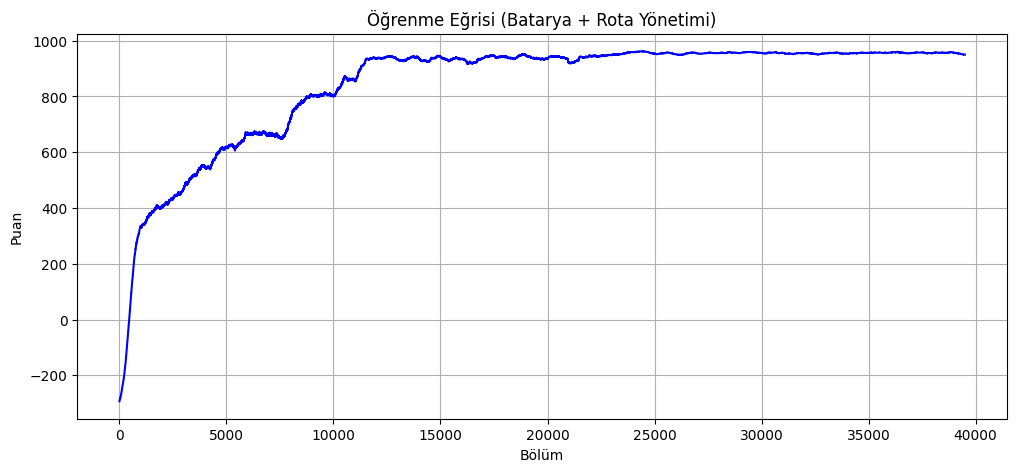

In [8]:
def moving_average(data, window_size=500):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 5))
plt.plot(moving_average(history_rewards), color='blue')
plt.title("Öğrenme Eğrisi (Batarya + Rota Yönetimi)")
plt.xlabel("Bölüm")
plt.ylabel("Puan")
plt.grid(True)
plt.show()